# Fake and Real News - Analysis and Recognition

### Author: Denislav Dyakov

## Abtract

In this paper, we analyze text data from around 44,000 real and fake articles. We build 12 new features (data columns) that describe the data and use those for testing our hypotheses. Our findings suggest that fake articles are associated with a higher number of  hashtags, exclamation marks, title and text subjectivity, as well as lower numer of quotations. At the same timethere is no statistically significant relation between article validity and the polarity of the title and text, as well as the use of upper case words. At the end of the article we build two classification models - a Naive Bayes classifier and a Logistic regression. The former performs with an accuracy of 88%, while the latter returns a 94% accuracy. The results need to be taken with a pintch of salt since in this paper, very little effort has been put into model adjustment and improvement.

## Introduction

In the words of Maxwell Fraser - the lead vocalist of British band "Faithless" - "misinformation is a weapon of mass desctruction" [1]. In fact in the English language we have two types of distortions of information: missinformation and disinformation. The former is defined as false information that "may not have been deliberately created or shared with the intention to mislead", while the latter is defined as false information "shared deliberately by a writer who might have a financial or political motive, e.g. propaganda" [2].


Whether one is worse that the other is not of particular interest to this paper. As both can result in negative consequences, we will treat them equally and throughout this paper refer to both as to "fake news". 
 
The problem of fake news has gained attention in recent years, especially after 2016, in the aftermath of the last U.S. presidential elections. The negative consiquences of fake news can be both tangible and non-tangible. According to a recent study people can easily recognize real news, but are “not good at identifying fake ones” [3]. 
 
In this paper we will first propose several hypotheses regarding fake news. We will test these hypotheses and at the end of the paper try to build a model that recognizes fake news.
 

## Previous Research

The topic is a heavily researched one in and out of academia. As of August 2020 a "fake news" search in Google Scholar returns around 60 thousand publications, while in Kaggle there are around 413 shared Notebooks, 110 Datasets and 14 Competitions.

One of the datasets that we will use is particularly popular in Kaggle. For example, in "Fake News Detection Naive Bayes Model" [6] the author builds a Naive Bayes Model similar to the one we construct here. And in "Fake News Classification" [7] they build both Naive Bayes and a Logistic Regression and compare the two classifiers' performance.

Our study builds upon previous research, as we:

- combine two separate datasets containing real and fake news
- add some additional features to the datasets that we analyse
- perform additional cleaning of the datasets, by trying to eliminate duplicate articles



## Conceptual Framework and Hypotheses

We list four aspects that can characterize fake news and form our hypotheses around those:

#### Emotional emphasis

Fake news tend to be the means for "emotional and often aggressive displays" [4]. When in text, such emphasis is done by the use of punctuation and capitalization. There we suggest that:

$ H_1a: $ Fake articles contain more upper case words that real ones

$ H_1b: $ Fake articles contain more exclamation marks that real ones 


#### Types of sources
According to MeaningCloud LLC, a company specializing in software for semantic analysis, the number of quotes from external sources is one of the predictors of whether a news is real or fake [5]. On the contrary, whenever a credible source is not available one would rely on subjective ones such as tweets and other social media posts. Because of that, we suggest that:
 

$ H_1c: $ Fake articles contain more hashtags and mentions that real ones

$ H_1d: $ Fake articles contain less quotations that real ones. 

#### Subjectivity
In addition, we argue that fake news, especially (bad fake news) tend to be more subjective. 

$ H_1e: $ Fake titles are more subjective that real news. 

$ H_1f: $ Fake articles are more subjective that real news. 

#### Negative connotation
Last but not least, we argue that fake news tend to put a negative connotation on the topic described. Therefore a news article that is fake would generally have a more negative polarization than a real one. These features would likely be present in both titles and articles alike. Therefore:

$ H_1g: $ Fake titles have a more negative polarity that real news.

$ H_1h: $ Fake articles have a more negative polarity that real news.

## Data sources and data cleaning

We will first analyze our data, perform some feature engineering by generating additional data columns needed for testing the proposed hypotheses. Afterwards we will go on and build a model that would predict whether a news article is real or fake. We start with importing our datasets.

For the purpose of this study, we will use readily available datasets, consisting of scraped news articles and their titles. The first dataset we will use is "Fake and real news dataset" [9], which we will download from Kaggle. It consists of two seprate csv files - one containing real articles and another containing fake articles. The other dataset we will use is called "News Data Set - Fake OR Real" [10]. It is again downloadable from Kaggle and its structure slightly differs.

Let us start by importing the modules we will need.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import scipy.stats as st

from textblob import TextBlob
from nltk.tokenize import word_tokenize, regexp_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import nltk

#from collections import Counter, defaultdict

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model  import LogisticRegression

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics                                                 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [3]:
pd.set_option('display.max_rows', 16)

We start by importing the first dataset and the fake articles csv.

In [4]:
df_fake = pd.read_csv("Fake.csv")

In [5]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_fake.shape

(23481, 4)

As shown above, we have 23,481 fake articles, their titles, a subject and a date. Since the owner of the datasets has not mentioned what kind of date this is, we can only assume that it is the date of posting the article. In addition, we do not have information regarding the subject of the articles and how were the artiles categorized. 

In [7]:
df_real = pd.read_csv("True.csv")

In [8]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


The two datasets come from the same source and naturally their structure in term of columns and formatting looks the same. Let us combine the two and also add an additional column indicating whether the article is fake or real.




In [9]:
df_fake["label"] = 1
df_real["label"] = 0

In [10]:
df_combined = pd.concat([df_fake, df_real])
df_combined.reset_index(drop=True, inplace=True)
assert (True in df_combined.index.duplicated()) == False, "Warning! Indexes are duplicated!"

In [11]:
df_combined.shape

(44898, 5)

In [12]:
df_combined.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


We notice that the combined dataset now has 44,898 articles. We will also shuffle the rows in the concatenated dataset.

In [13]:
df_combined = df_combined.sample(len(df_combined))

In [14]:
df_combined.head()

,title,text,subject,date,label
43449,Merkel can well imagine a European finance min...,BERLIN (Reuters) - German Chancellor Angela Me...,worldnews,"September 15, 2017",0
14959,BOOM! Ben Carson Eviscerates Rabid Media Over ...,Ben Carson s professional but hard hitting app...,politics,"Nov 7, 2015",1
29265,Trump Supreme Court nominee Gorsuch seen in th...,"Federal appeals court judge Neil Gorsuch, the ...",politicsNews,"February 1, 2017",0
39073,Lebanon monetary situation stable after PM qui...,BEIRUT (Reuters) - Lebanon s monetary situatio...,worldnews,"November 6, 2017",0
25679,Trump chides Merck CEO after resignation from ...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"August 14, 2017",0


As we see, the rows are now shuffled. Let us now check the quality of our data. The dataset description states that we have unique values. Let us check if this is so, starting with the "titles" column.

In [15]:
df_combined["title"].value_counts()

Factbox: Trump fills top jobs for his administration                                                     14
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                          8
Factbox: Contenders for senior jobs in Trump's administration                                             8
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
                                                                                                         ..
Three vehicles torched in long-running South African taxi war                                             1
 Trump Spokeswoman On Rally Violence: It’s Just A ‘Head-On Collision With The Truth’ (VIDEO)              1
 Americans UNLOAD On Trump For Threatening North Korea And China On Twitter                               1
Putin told Tillerson why U.S

As we see, the data does not seem as cleaned as it is suggested on Kaggle. Let us check several examples and see why there are non-unique titles. But is this maybe intentional? Could we have the same title with different contents for each record? This might be the title of a regular news column that does not change, only the contents are updated. We need to check if the "text" is different for each non-unique title.

In [16]:
df_combined[df_combined["title"] == "Factbox: Contenders for senior jobs in Trump's administration"]

,title,text,subject,date,label
30009,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,politicsNews,"January 4, 2017",0
30087,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,politicsNews,"December 22, 2016",0
30191,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following are people mentioned...,politicsNews,"December 14, 2016",0
30240,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following are people mentioned...,politicsNews,"December 12, 2016",0
30164,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,politicsNews,"December 15, 2016",0
30108,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,politicsNews,"December 20, 2016",0
30115,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,politicsNews,"December 19, 2016",0
30135,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,politicsNews,"December 17, 2016",0


In [17]:
print(df_combined[df_combined["title"] == "Factbox: Contenders for senior jobs in Trump's administration"]["text"].str.len())

30009    3011
30087    3596
30191    2778
30240    4180
30164    3013
30108    3386
30115    3007
30135    2844
Name: text, dtype: int64


The different lengths suggest that maybe we have different content in an article with a repeating title.But how many such cases do we have in this dataset?

In [18]:
df_combined.groupby("title").filter(lambda x: x["title"].count() > 1).sort_values("title")

,title,text,subject,date,label
1535,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,News,"May 10, 2017",1
1488,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,News,"May 12, 2017",1
14160,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,politics,"Apr 6, 2016",1
20771,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,left-news,"Apr 6, 2016",1
17930,#Austin: Fights Break Out Between Police and S...,Commies carrying flags fought with the Austin ...,left-news,"Sep 23, 2017",1
...,...,...,...,...,...
19149,“Would You Rather Do A Job You Hate And Not Pa...,"Filmmaker and patriot, Dennis Michael Lynch is...",left-news,"Feb 12, 2017",1
14235,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...,"No matter which candidate you support, this mo...",politics,"Mar 21, 2016",1
16696,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...,"No matter which candidate you support, this mo...",Government News,"Mar 21, 2016",1
15113,“You’re Not Welcome!” Obama As Welcome At Rose...,Roseberg residents and families of victims are...,politics,"Oct 7, 2015",1


Almost 11,800 cases of article titles that appear more than once. This seems alot compared to the sample of almost 45,000 articles. Let us try to fix this, by removing the sure duplicates. We will split the dataset in two - one with no duplicates and one with possible duplicates. We will clean each of the two individually and then concatenate them.

In [19]:
no_duplicates = df_combined.groupby("title").filter(lambda x: x["title"].count() == 1).sort_values("title")

In [20]:
no_duplicates.shape

(33100, 5)

In [21]:
possible_duplicates = df_combined.groupby("title").filter(lambda x: x["title"].count() > 1).sort_values("title")

In [22]:
possible_duplicates.shape

(11798, 5)

In [23]:
assert df_combined.shape[0] == int(no_duplicates.shape[0]) + int(possible_duplicates.shape[0]), "Set is not correctly split!"

Let us first begin with the possibly duplicated set, since it might require more effort to clean.

In [24]:
possible_duplicates.head(20)

,title,text,subject,date,label
1535,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,News,"May 10, 2017",1
1488,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,News,"May 12, 2017",1
14160,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,politics,"Apr 6, 2016",1
20771,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,left-news,"Apr 6, 2016",1
17930,#Austin: Fights Break Out Between Police and S...,Commies carrying flags fought with the Austin ...,left-news,"Sep 23, 2017",1
...,...,...,...,...,...
21450,#BlackLivesMatter Terrorists Using #BlackRail ...,Sanctioned domestic terrorists taking directio...,left-news,"Sep 19, 2015",1
21197,#BlackLivesMatterTerrorists Shut Down Kids Vis...,These poor kids have probably practiced for mo...,left-news,"Dec 23, 2015",1
14758,#BlackLivesMatterTerrorists Shut Down Kids Vis...,These poor kids have probably practiced for mo...,politics,"Dec 23, 2015",1
21348,#BlackPrivilegedLives: Truth Behind The (Not S...,We ll wait for Nancy Pelosi to call this movem...,left-news,"Nov 11, 2015",1


As we see, one possible reason for duplication would be to have the same article and title, but different "subject" and "date". 

In [25]:
possible_duplicates["text"].str.len()

1535     2937
1488     2957
14160    1318
20771    1318
17930    1461
         ... 
19149     362
14235    2555
16696    2555
15113    2737
21428    2737
Name: text, Length: 11798, dtype: int64

This suggestion is reaffirmed by the identical length of text in some of the possibly duplicated articles. Let us examine one such case:

In [26]:
df_dublicate1 = possible_duplicates[possible_duplicates.index == 14160]["text"]
df_dublicate2 = possible_duplicates[possible_duplicates.index == 20771]["text"]
assert df_dublicate1.tolist() == df_dublicate2.tolist(), "Texts are not identical"

Indeed, this seems to be the case. Since we would like to avoid having duplicated articles, and since the usefulness provided by the "subject" and "date" columns is questionable, we will go on and drop these two columns. Afterwards we will drop all duplicated rows. 

In [27]:
possible_duplicates = possible_duplicates.drop(["subject", "date"], axis = 1)

In [28]:
possible_duplicates.shape

(11798, 3)

In [29]:
possible_duplicates_cleaned = possible_duplicates.drop_duplicates(keep = "first")

In [30]:
possible_duplicates_cleaned.shape

(6005, 3)

As we see, around 5,800 duplicates were removed and around 6,000 non duplicated articles remain. But has this approach solved our problem?

In [31]:
possible_duplicates_cleaned.groupby("title").filter(lambda x: x["title"].count() > 1).sort_values("title")

,title,text,label
1535,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,1
1488,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,1
38512,'Can I get it to go?' Canada's Trudeau charms ...,MANILA (Reuters) - Canadian Prime Minister Jus...,0
24155,'Can I get it to go?' Canada's Trudeau charms ...,MANILA (Reuters) - Canadian Prime Minister Jus...,0
35950,'Fierce and formidable' Dlamini-Zuma eyes Sout...,JOHANNESBURG (Reuters) - Nkosazana Dlamini-Zum...,0
...,...,...,...
39253,"World 'running out of time' on North Korea, Tr...",WASHINGTON (Reuters) - U.S. President Donald T...,0
38791,"Xi says China to be more open, transparent to ...",BEIJING (Reuters) - Chinese President Xi Jinpi...,0
24215,"Xi says China to be more open, transparent to ...",BEIJING (Reuters) - Chinese President Xi Jinpi...,0
15815,[Video] WATCH HOW MARCO RUBIO Handles Same Rep...,There s just something about Shrillary that al...,1


In [32]:
possible_duplicates_cleaned.groupby("title").filter(lambda x: x["title"].count() > 1)["text"].str.len()

1535     2937
1488     2957
38512    2307
24155    2307
35950    5502
         ... 
39253    3532
38791     384
24215     384
15815     233
21843     247
Name: text, Length: 716, dtype: int64

Apparently there are still 716 articles with identical titles, some of these with the same length text, others with a different length text. Let us check several example to get a better idea of why the former were not dropped as duplicates.  

In [33]:
df_dublicate3 = possible_duplicates[possible_duplicates.index == 24215]["text"]
df_dublicate4 = possible_duplicates[possible_duplicates.index == 38791]["text"]
#assert df_dublicate1.tolist() == df_dublicate2.tolist(), "Texts are not identical"
df_dublicate3.tolist()

['BEIJING (Reuters) - Chinese President Xi Jinping said on Thursday China will be more open and transparent to foreign companies, including those from the United States.  U.S. companies are also welcome to take part in China’s Belt and Road initiative, Xi told a briefing in Beijing after talks with U.S. President Donald Trump. China’s door to the world will only open wider, he said. ']

In [34]:
df_dublicate4.tolist()

['BEIJING (Reuters) - Chinese President Xi Jinping said on Thursday China will be more open and transparent to foreign companies, including those from the United States.  U.S. companies are also welcome to take part in China s Belt and Road initiative, Xi told a briefing in Beijing after talks with U.S. President Donald Trump. China s door to the world will only open wider, he said. ']

In [35]:
df_dublicate3.tolist() == df_dublicate4.tolist()

False

They seem identical, but are not recognized as such. Maybe we are dealing with some hidden characters here.

In [36]:
ascii(df_dublicate3.tolist())

"['BEIJING (Reuters) - Chinese President Xi Jinping said on Thursday China will be more open and transparent to foreign companies, including those from the United States.  U.S. companies are also welcome to take part in China\\u2019s Belt and Road initiative, Xi told a briefing in Beijing after talks with U.S. President Donald Trump. China\\u2019s door to the world will only open wider, he said. ']"

In [37]:
ascii(df_dublicate4.tolist())

"['BEIJING (Reuters) - Chinese President Xi Jinping said on Thursday China will be more open and transparent to foreign companies, including those from the United States.  U.S. companies are also welcome to take part in China s Belt and Road initiative, Xi told a briefing in Beijing after talks with U.S. President Donald Trump. China s door to the world will only open wider, he said. ']"

Indeed from the ascii representation, we see that there are some differences. At this point we decide that around 350 duplicated articles is an error we are willing to accept, and will leave these as they are. This is of course a compromise that is not acceptable in future research.

Let us continue and this time instead of identical titles, we check identical texts that have a different title.

In [38]:
possible_duplicates_cleaned.groupby("text").filter(lambda x: x["text"].count() > 1).sort_values("text")

,title,text,label
21786,(VIDEO) BALTIMORE MAYOR REOPENS LOOTED MALL: T...,,1
19461,SCROOGE PASTOR HECKLES Kids Waiting In Line Fo...,,1
18897,SEAN SPICER CALLS OUT Race Baiting Journalist:...,,1
18924,SEAN SPICER HITS LAME CNN: “Let’s actually loo...,,1
19646,SEATTLE CITY COUNCILWOMAN Incites Riot…Vows To...,,1
...,...,...,...
19050,MULTI-MILLIONAIRE Global-Warming Hypocrites LE...,Enjoy:,1
19953,WHOA! NEW DISTURBING VIDEO Shows HILLARY’S Cam...,"On September 15, Hillary apparently held a r...",1
19952,DISTURBING VIDEO Shows HILLARY’S Campaign Like...,"On September 15, Hillary apparently held a r...",1
9738,LEFTIST STORE OWNER Makes Video Asking Libs To...,Things didn t go as well as Nicholle had hoped...,1


Indeed there are around 180 articles with identical texts but with different titles. Namely the different titles spared these from being dropped. Since the number is relatively small to the total number of articles in our sample, we will ignore this duplication. We only want to check the first several articles that seem to have no text. Is this simply an empty article or is it some empty string that visualizes before the article itself? Let us find out by checking the lengths of the text column.

In [39]:
possible_duplicates_cleaned[possible_duplicates_cleaned["text"].str.len() < 50]["text"].sort_values(ascending = True)

21786                                               
19322                                               
13045                                               
16425                                               
11249                                               
                            ...                     
12064    https://www.youtube.com/watch?v=wYdX071Nlow
11730    https://www.youtube.com/watch?v=zZ7GrEItGoo
12328                   https://youtu.be/0J4xPRYbsLU
12252                   https://youtu.be/RTuxvWjH3a4
12402                   https://youtu.be/kKFQ5i9jXmA
Name: text, Length: 227, dtype: object

In [40]:
empty_string_filter = possible_duplicates_cleaned["text"].str.len() < 50

In [41]:
possible_duplicates_cleaned[empty_string_filter]

,title,text,label
21786,(VIDEO) BALTIMORE MAYOR REOPENS LOOTED MALL: T...,,1
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,1
15842,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,1
15710,(VIDEO) KRAUTHAMMER: FORMER CIA DEPUTY DIRECTO...,,1
15771,(VIDEO) RIOTERS TAKE SELFIES WITH TORCHED POLI...,,1
...,...,...,...
11730,“F*ck Trump! F*ck White People!” LEFTY GOES NU...,https://www.youtube.com/watch?v=zZ7GrEItGoo,1
20609,“I Think My Dog’s A Democrat” [VIDEO],A MUST watch video!https://youtu.be/-5Z-jJ2Z4bU,1
16268,“LITTLE” MARCO RUBIO GRILLS Trump’s Secretary ...,,1
19272,"“THANK YOU BABY”…YES, FEMINISTS WILL GO NUTS: ...",https://www.youtube.com/watch?v=9LNyx_DWzzA,1


As we see there are some articles that only consist of a link or that are entirely empty. We will proceed with dropping these rows since they would not provide any value for our analysis.

In [42]:
possible_duplicates_cleaned.loc[empty_string_filter, "text"] = np.nan

C:\Users\Denis\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [43]:
possible_duplicates_cleaned = possible_duplicates_cleaned.dropna()

In [44]:
possible_duplicates_cleaned

,title,text,label
1535,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,1
1488,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,1
14160,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,1
17930,#Austin: Fights Break Out Between Police and S...,Commies carrying flags fought with the Austin ...,1
19211,#Berkeley CRAZY! RIOTERS CHASE And Beat People...,Is anyone else thinking what we re thinking ab...,1
...,...,...,...
11463,“WOODY” KAINE One Of Six ARRESTED After Peacef...,Watch the local news report as they explain wh...,1
18399,“We are progressive”: Activist Defends $190K P...,Immigration advocate Roberto Hernandez joined ...,1
16247,“Would You Rather Do A Job You Hate And Not Pa...,"Filmmaker and patriot, Dennis Michael Lynch is...",1
14235,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...,"No matter which candidate you support, this mo...",1


In [45]:
possible_duplicates_cleaned[possible_duplicates_cleaned["text"].str.len() < 50]["text"].sort_values(ascending = True)

Series([], Name: text, dtype: object)

At this point we believe this is as far as we will go in cleaning our dataset. We will perform some cleaning on the no_duplicates dataset too.


In [46]:
no_duplicates

,title,text,subject,date,label
7786,\r\r\r\r\r\r\r\nDonald Trump Gets His A** Hand...,"A 10-year-old girl smacked down Donald Trump, ...",News,"February 29, 2016",1
1050,\r\r\r\r\r\r\r\nEx-GOP Congressman Shreds Fell...,"At this point, every Republican who refuses to...",News,"June 22, 2017",1
3930,\r\r\r\r\r\r\r\nTrump Gets STOMPED For Whining...,Donald Trump has been attacking President Obam...,News,"November 5, 2016",1
1594,\r\r\r\r\r\r\r\nWATCH: Democratic Rep Delivers...,Massachusetts Rep. Jim McGovern brought the Ho...,News,"May 4, 2017",1
5161,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,News,"August 5, 2016",1
...,...,...,...,...,...
21306,“White Student Union” Forms Facebook Page To O...,This Barack Obama-Eric Holder inspired anti-Am...,left-news,"Nov 21, 2015",1
18018,“White people are born into not being human” –...,Ashleigh Shackelford is what passes for a seri...,left-news,"Sep 4, 2017",1
13198,"“Without Coal, This State Is Nothing”…WEST VIR...",We re going to put a lot of coal miners and c...,politics,"Aug 22, 2016",1
11943,“YOU ARE FAKE NEWS!” TRUMP DESTROYS CNN Right ...,,politics,"Jan 11, 2017",1


Again dropping the columns that do not bring any value, as well as dropping the articles that have less than 50 symbols.

In [47]:
no_duplicates = no_duplicates.drop(["subject", "date"], axis = 1)

In [48]:
no_duplicates.head()

,title,text,label
7786,\r\r\r\r\r\r\r\nDonald Trump Gets His A** Hand...,"A 10-year-old girl smacked down Donald Trump, ...",1
1050,\r\r\r\r\r\r\r\nEx-GOP Congressman Shreds Fell...,"At this point, every Republican who refuses to...",1
3930,\r\r\r\r\r\r\r\nTrump Gets STOMPED For Whining...,Donald Trump has been attacking President Obam...,1
1594,\r\r\r\r\r\r\r\nWATCH: Democratic Rep Delivers...,Massachusetts Rep. Jim McGovern brought the Ho...,1
5161,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,1


In [49]:
no_duplicates[no_duplicates["text"].str.len() < 50]["text"].sort_values(ascending = True)

11792                                               
11625                                               
11860                                               
21780                                               
12261                                               
                            ...                     
11966    https://www.youtube.com/watch?v=tY0ApLE6dns
11626    https://www.youtube.com/watch?v=uCS4RB9G13M
12255    https://www.youtube.com/watch?v=uQbAww5wajA
12183                   https://youtu.be/7oOhwHG2Gb4
12265                   https://youtu.be/Ai5ayloRa-0
Name: text, Length: 364, dtype: object

In [50]:
empty_string_filter = no_duplicates["text"].str.len() < 50

In [51]:
no_duplicates[empty_string_filter]

,title,text,label
11792,#FireBenStein FOX NEWS’ BEN STEIN Calls Presid...,,1
15449,(VIDEO) BRAVO! TV HOST SCORCHES OBAMA FOR HIS ...,I VE HAD IT!,1
15718,(VIDEO) CLINTON FOUNDATION HOSTS FUNDRAISERS ‘...,,1
15693,(VIDEO) DID HE JUST SAY THAT?! OBAMA DOWNPLAYS...,,1
15682,(VIDEO) FORMER DEFENSE SECRETARY EXPRESSES CON...,,1
...,...,...,...
12940,“PEOPLE ARE HUGGING?”…”PEACEFUL PROTEST?” What...,,1
12379,"“SUCK IT UP, BUTTERCUP!”…Iowa Lawmaker Names B...",,1
12114,“So Rude!” Nancy Pelosi’s Daughter Blasted By ...,,1
11943,“YOU ARE FAKE NEWS!” TRUMP DESTROYS CNN Right ...,,1


In [52]:
no_duplicates.loc[empty_string_filter, "text"] = np.nan

In [53]:
no_duplicates[empty_string_filter]

,title,text,label
11792,#FireBenStein FOX NEWS’ BEN STEIN Calls Presid...,NaN,1
15449,(VIDEO) BRAVO! TV HOST SCORCHES OBAMA FOR HIS ...,NaN,1
15718,(VIDEO) CLINTON FOUNDATION HOSTS FUNDRAISERS ‘...,NaN,1
15693,(VIDEO) DID HE JUST SAY THAT?! OBAMA DOWNPLAYS...,NaN,1
15682,(VIDEO) FORMER DEFENSE SECRETARY EXPRESSES CON...,NaN,1
...,...,...,...
12940,“PEOPLE ARE HUGGING?”…”PEACEFUL PROTEST?” What...,NaN,1
12379,"“SUCK IT UP, BUTTERCUP!”…Iowa Lawmaker Names B...",NaN,1
12114,“So Rude!” Nancy Pelosi’s Daughter Blasted By ...,NaN,1
11943,“YOU ARE FAKE NEWS!” TRUMP DESTROYS CNN Right ...,NaN,1


In [54]:
no_duplicates = no_duplicates.dropna()

In [55]:
no_duplicates.shape

(32736, 3)

In [56]:
no_duplicates.head()

,title,text,label
7786,\r\r\r\r\r\r\r\nDonald Trump Gets His A** Hand...,"A 10-year-old girl smacked down Donald Trump, ...",1
1050,\r\r\r\r\r\r\r\nEx-GOP Congressman Shreds Fell...,"At this point, every Republican who refuses to...",1
3930,\r\r\r\r\r\r\r\nTrump Gets STOMPED For Whining...,Donald Trump has been attacking President Obam...,1
1594,\r\r\r\r\r\r\r\nWATCH: Democratic Rep Delivers...,Massachusetts Rep. Jim McGovern brought the Ho...,1
5161,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,1


We see that there are some article titles that have new line characters in the beginning. These should too be cleaned.

In [57]:
no_duplicates = no_duplicates.replace("\r|\n", "", regex=True)

In [58]:
no_duplicates.head()

,title,text,label
7786,Donald Trump Gets His A** Handed To Him By A 1...,"A 10-year-old girl smacked down Donald Trump, ...",1
1050,Ex-GOP Congressman Shreds Fellow Republicans F...,"At this point, every Republican who refuses to...",1
3930,Trump Gets STOMPED For Whining About President...,Donald Trump has been attacking President Obam...,1
1594,WATCH: Democratic Rep Delivers Scathing Rebuke...,Massachusetts Rep. Jim McGovern brought the Ho...,1
5161,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,1


Now we can concatenate the two cleaned subsets.

In [59]:
df_combined_cleaned = pd.concat([no_duplicates, possible_duplicates_cleaned])
df_combined_cleaned.reset_index(drop=True, inplace=True)
assert (True in df_combined_cleaned.index.duplicated()) == False, "Warning! Indexes are duplicated!"

In [60]:
df_combined_cleaned

,title,text,label
0,Donald Trump Gets His A** Handed To Him By A 1...,"A 10-year-old girl smacked down Donald Trump, ...",1
1,Ex-GOP Congressman Shreds Fellow Republicans F...,"At this point, every Republican who refuses to...",1
2,Trump Gets STOMPED For Whining About President...,Donald Trump has been attacking President Obam...,1
3,WATCH: Democratic Rep Delivers Scathing Rebuke...,Massachusetts Rep. Jim McGovern brought the Ho...,1
4,#AfterTrumpImplodes Hashtag Hilariously Imagi...,What will the world be like post-Donald Trump?...,1
...,...,...,...
38509,“WOODY” KAINE One Of Six ARRESTED After Peacef...,Watch the local news report as they explain wh...,1
38510,“We are progressive”: Activist Defends $190K P...,Immigration advocate Roberto Hernandez joined ...,1
38511,“Would You Rather Do A Job You Hate And Not Pa...,"Filmmaker and patriot, Dennis Michael Lynch is...",1
38512,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...,"No matter which candidate you support, this mo...",1


This is as far as we will go in cleaning our first dataset. We have separated our dataset in two: one containing no duplicates and one containing possible duplicates. We have identified obvious duplicates, and removed those. We have also removed articles that contain text with less than 50 characters, as well as empty strings. Lastly we will concatenate the two.

Additionaly, we have decided to diversify our data, and add another dataset. We will follow the same steps as before: import, check for duplicates, separate into two subsets, clean them separately and then concatenate them into a single cleaned dataset.

In [61]:
df_news = pd.read_csv("news_datasets.csv")
df_news.head()
df_news["label"] = df_news["label"].replace({"FAKE": 1, "REAL": 0})
df_news = df_news.drop(["Unnamed: 0"], axis = 1)
df_news.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


We will perform the same checks as in the first dataset, namely check for duplicate values, and drop empty and articles with less than 50 symbols if there are any.

In [62]:
df_news_possible_duplicates = df_news.groupby("title").filter(lambda x: x["title"].count() > 1).sort_values("title")
df_news_no_duplicates = df_news.groupby("title").filter(lambda x: x["title"].count() == 1).sort_values("title")

df_news_possible_duplicates = df_news_possible_duplicates.drop_duplicates(keep = "first")
df_news_no_duplicates = df_news_no_duplicates.drop_duplicates(keep = "first")

empty_string_filter = df_news_no_duplicates["text"].str.len() < 50
df_news_no_duplicates[empty_string_filter]
df_news_no_duplicates.loc[empty_string_filter, "text"] = np.nan
df_news_no_duplicates = df_news_no_duplicates.dropna()

df_news_cleaned = pd.concat([df_news_no_duplicates, df_news_possible_duplicates])
df_news_cleaned.reset_index(drop=True, inplace=True)
assert (True in df_news_cleaned.index.duplicated()) == False, "Warning! Indexes are duplicated!"

In [63]:
df_news_cleaned.shape

(6261, 3)

Now that the second dataset is cleaned too, we can concatenate it to the first.

In [64]:
df_cleaned = pd.concat([df_news_cleaned, df_combined_cleaned])
df_cleaned.reset_index(drop=True, inplace=True)
assert (True in df_cleaned.index.duplicated()) == False, "Warning! Indexes are duplicated!"

In [65]:
df_cleaned.shape

(44775, 3)

In [66]:
df_cleaned.head()

,title,text,label
0,"""America has a simple ideology"": how one of Ru...",The United States comes up constantly when you...,0
1,"""Political identity is fair game for hatred"": ...","In 1960, Americans were asked whether they wou...",0
2,"""Russia is concentrating"" 2.0: Putin's new pol...","October 28, 2016 - By Eduard Popov for Fort R...",1
3,"""Top Five Clinton Donors Are Jewish"" - How Ant...","""Top Five Clinton Donors Are Jewish"" - How Ant...",1
4,#2816: Clinton Pride’s 8(a) Pig Farm Bridge – ...,United States Marine Field McConnell Plum Cit...,1


In [67]:
df_cleaned = df_cleaned.sample(len(df_cleaned))

We also want to check if there are any duplicates between the two datasets and apparantly there aren't any.

In [68]:
assert df_cleaned.equals(df_cleaned.drop_duplicates(keep = "first")) == True,\
"There are some duplicates between the combined datasets"

In [69]:
df_cleaned.label.value_counts()

0    24349
1    20426
Name: label, dtype: int64

In [70]:
df_cleaned.label.value_counts() / len(df_cleaned)

0    0.543808
1    0.456192
Name: label, dtype: float64

This is out final cleaned dataset. As we can see, it is slightly skewed in favour of the real news articles.

#### New Features Engineering

In order to better analyze our dataset and potentially test the hypotheses we have proposed, we need to generate several additional columns.

We will start with the features related to emotional emphasis in text - namely upper case words and exclamation marks. We will define a function that extracts the capitalized words in each article, and stores them in a list, as well as another list containing the count of upper case words.

In [71]:
def extract_capitalized_words(column_name, dataset):
    pattern = r"[A-Z]{3,}"

    capitalized = []
    count_capitalized = []

    for element in dataset[column_name]:
        word = regexp_tokenize(element, pattern)
        capitalized.append(word)
        count_capitalized.append(len(word))
        
    return capitalized, count_capitalized

In [72]:
capitalized, count_capitalized = extract_capitalized_words("text", df_cleaned)

We have set a cutoff point for the length of the capitalized word - anything shorter than 3 symbols is not taken into account.

In [73]:
capitalized[:5]

[[],
 ['BRITISH',
  'COLUMNIST',
  'KATIE',
  'HOPKINS',
  'BRUTAL',
  'VIDEO',
  'NEW',
  'ZEALAND',
  'TRANSGENDER',
  'WINS',
  'WEIGHTLIFTING',
  'TITLE'],
 [],
 [],
 ['NEW', 'YORK']]

In [74]:
count_capitalized[:5]

[0, 12, 0, 0, 2]

It seems that the function returns what is expencted. We will go on and append the new columns to the cleaned dataset.

In [75]:
df_cleaned["capitalized"] = capitalized
df_cleaned["count_capitalized"] = count_capitalized
df_cleaned.shape

(44775, 5)

We would also need to do the same for the number of exclamation marks used in an article.

In [76]:
def extract_exclamation_marks(column_name, dataset):
    pattern = r"!"

    count_exclamations = []

    for element in dataset[column_name]:
        mark = regexp_tokenize(element, pattern)
        count_exclamations.append(len(mark))
        
    return count_exclamations

In [77]:
count_exclamations = extract_exclamation_marks("text", df_cleaned)

In [78]:
count_exclamations[:5]

[0, 0, 2, 0, 0]

In [79]:
df_cleaned["count_exclamations"] = count_exclamations
df_cleaned.shape

(44775, 6)

In addition, we need to extract the hashtags and mentions from tweets, used in each of the articles

In [80]:
def extract_hashtags(column_name, dataset):
    pattern = r"([@#]\w+)"

    hashtags = []
    count_hashtags = []

    for element in dataset[column_name]:
        hashtag = regexp_tokenize(element, pattern)
        hashtags.append(hashtag)
        count_hashtags.append(len(hashtag))
        
    return hashtags, count_hashtags

In [81]:
hashtags, count_hashtags = extract_hashtags("text", df_cleaned)

In [82]:
hashtags[:5]

[[], [], [], [], []]

In [83]:
count_hashtags[:5]

[0, 0, 0, 0, 0]

In [84]:
df_cleaned["hashtags"] = hashtags
df_cleaned["count_hashtags"] = count_hashtags
df_cleaned.shape

(44775, 8)

On the contrary, we need to also extract the number of quotations used in each article.

In [85]:
def extract_quotation_marks(column_name, dataset):
    pattern = r"”|“"

    count_quotations = []

    for element in dataset[column_name]:
        mark = regexp_tokenize(element, pattern)
        count_quotations.append(len(mark))
        
    return count_quotations

In [86]:
count_quotations = extract_quotation_marks("text", df_cleaned)

In [87]:
count_quotations[:5]

[0, 0, 0, 0, 4]

In [88]:
df_cleaned["count_quotations"] = count_quotations
df_cleaned.shape

(44775, 9)

Additionaly, we would like to get additional data regardig the sentiment of each article. For this purpose, we will make use of the "textblob" module and the "sentiment" function within it. It outputs two values. One is "polarity" - it lies in the range of [-1, 1] where 1 means positive statement and -1 means a negative statement. The other is "subjectivity" - it lies in the range of [0, 1] where 0 indicates that a text is objective and 1 means that a text is subjective.

In [89]:
def extract_polarity_subjectivity(column_name, dataset):
    
    polarity = []
    subjectivity = []

    for element in dataset[column_name]:
        sentiment = TextBlob(element).sentiment
        polarity.append(sentiment[0])
        subjectivity.append(sentiment[1])
    
    return polarity, subjectivity

In [90]:
polarity_text, subjectivity_text = extract_polarity_subjectivity("text", df_cleaned)

In [91]:
polarity_text[:5]

[0.0010885250015684792,
 0.09875874125874126,
 0.1650093370681606,
 0.11038961038961038,
 0.06945475159760875]

In [92]:
subjectivity_text[:5]

[0.36176046176046167,
 0.3982983682983683,
 0.35071195144724565,
 0.4555844155844156,
 0.4296639868068439]

In [93]:
polarity_title, subjectivity_title = extract_polarity_subjectivity("title", df_cleaned)

In [94]:
polarity_title[:5]

[0.11666666666666668, -0.025000000000000005, 0.08148148148148147, 0.5, 0.0]

In [95]:
subjectivity_title[:5]

[0.5166666666666666, 0.26666666666666666, 0.562962962962963, 0.5, 0.0]

In [96]:
#df_cleaned.drop(["polarity_title", "subjectivity_title"], axis = 1)

In [97]:
df_cleaned["polarity_text"] = polarity_text
df_cleaned["subjectivity_text"] = subjectivity_text

df_cleaned["polarity_title"] = polarity_title
df_cleaned["subjectivity_title"] = subjectivity_title
df_cleaned.shape

(44775, 13)

Last but not least, we will also extract the lengths of both titles and texts.

In [98]:
def extract_lengths(column_name, dataset):
    
    lengths = []

    for element in dataset[column_name]:
        length = len(element)
        lengths.append(length)
    
    return lengths

In [99]:
lengths_title = extract_lengths("title", df_cleaned)

In [100]:
lengths_text = extract_lengths("text", df_cleaned)

In [101]:
lengths_title[:5]

[102, 69, 140, 62, 64]

In [102]:
lengths_text[:5]

[4070, 772, 1757, 752, 2196]

In [103]:
df_cleaned["lengths_title"] = lengths_title
df_cleaned["lengths_text"] = lengths_text
df_cleaned.shape

(44775, 15)

And this is what our dataset looks like.

In [104]:
df_cleaned.dtypes

title                  object
text                   object
label                   int64
capitalized            object
count_capitalized       int64
count_exclamations      int64
hashtags               object
count_hashtags          int64
count_quotations        int64
polarity_text         float64
subjectivity_text     float64
polarity_title        float64
subjectivity_title    float64
lengths_title           int64
lengths_text            int64
dtype: object

In [105]:
df_cleaned.head()

,title,text,label,capitalized,count_capitalized,count_exclamations,hashtags,count_hashtags,count_quotations,polarity_text,subjectivity_text,polarity_title,subjectivity_title,lengths_title,lengths_text
6327,"A Dallas Cop Just Filed Suit Against Obama, H...","A Dallas police officer, seeing red after seve...",1,[],0,0,[],0,0,0.001089,0.361760,0.116667,0.516667,102,4070
37921,"WELL, DUH! Transgender Wins International Wome...",Just last month a transgender high school wres...,1,"[BRITISH, COLUMNIST, KATIE, HOPKINS, BRUTAL, V...",12,0,[],0,0,0.098759,0.398298,-0.025000,0.266667,69,772
44601,YOUNG MAN DELIVERS POWERFUL Message To Liberal...,Wow! This young Asian student nails it! He spe...,1,[],0,2,[],0,0,0.165009,0.350712,0.081481,0.562963,140,1757
27955,POLL SHOWS WHICH Candidate Will Benefit Most F...,"If Rubio would have dropped out a month ago, w...",1,[],0,0,[],0,0,0.110390,0.455584,0.500000,0.500000,62,752
21293,Federal prosecutors question NYC mayor over fu...,NEW YORK (Reuters) - New York City Mayor Bill ...,0,"[NEW, YORK]",2,0,[],0,4,0.069455,0.429664,0.000000,0.000000,64,2196


### Explortory Data Analysis

Let us check the descriptive statistics for the columns in our dataset

In [106]:
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
label,44775.0,0.456192,0.498083,0.0,0.000000,0.000000,1.000000,1.0
count_capitalized,44775.0,4.267850,7.708854,0.0,1.000000,2.000000,5.000000,351.0
count_exclamations,44775.0,0.392362,1.576697,0.0,0.000000,0.000000,0.000000,133.0
count_hashtags,44775.0,0.745572,3.607284,0.0,0.000000,0.000000,0.000000,131.0
count_quotations,44775.0,3.933289,10.083977,0.0,0.000000,0.000000,4.000000,541.0
polarity_text,44775.0,0.059446,0.102548,-1.0,0.003788,0.057790,0.110237,1.0
subjectivity_text,44775.0,0.406305,0.120812,0.0,0.343299,0.410991,0.475582,1.0
polarity_title,44775.0,0.016453,0.257143,-1.0,0.000000,0.000000,0.050000,1.0
subjectivity_title,44775.0,0.263484,0.322832,0.0,0.000000,0.100000,0.500000,1.0
lengths_title,44775.0,75.016304,22.713616,1.0,61.000000,70.000000,85.000000,289.0


We can immediately see that there are article titles consisting of one symbol. Apart from that there is no missing data. We can confirm this with the following command too:

In [107]:
df_cleaned.isnull().sum()

title                 0
text                  0
label                 0
capitalized           0
count_capitalized     0
count_exclamations    0
hashtags              0
count_hashtags        0
count_quotations      0
polarity_text         0
subjectivity_text     0
polarity_title        0
subjectivity_title    0
lengths_title         0
lengths_text          0
dtype: int64

Let us check this short title. We can see that it is only one, and since titles will not be text mined later on, when we build our classifiers, we will ignore this and leave it as it is.

In [108]:
df_cleaned[df_cleaned["lengths_title"] < 10]["title"]

836      Candidate
4120     Rick Rule
3653      Ooh Fuck
5377     Tweetwave
5766         White
22821     Homepage
5341      Trumped!
184              :
5937     Wikileaks
Name: title, dtype: object

One quick and dirty way of getting an idea of the distributions of your dta is to do a pairlot. It will include all columns in our dataset that can be plotted one against another. As we can see, even if it contains some useful insights, it will take a while to get yourself acquainted with it. Adding more columns can make it look quite messy and unreadable.

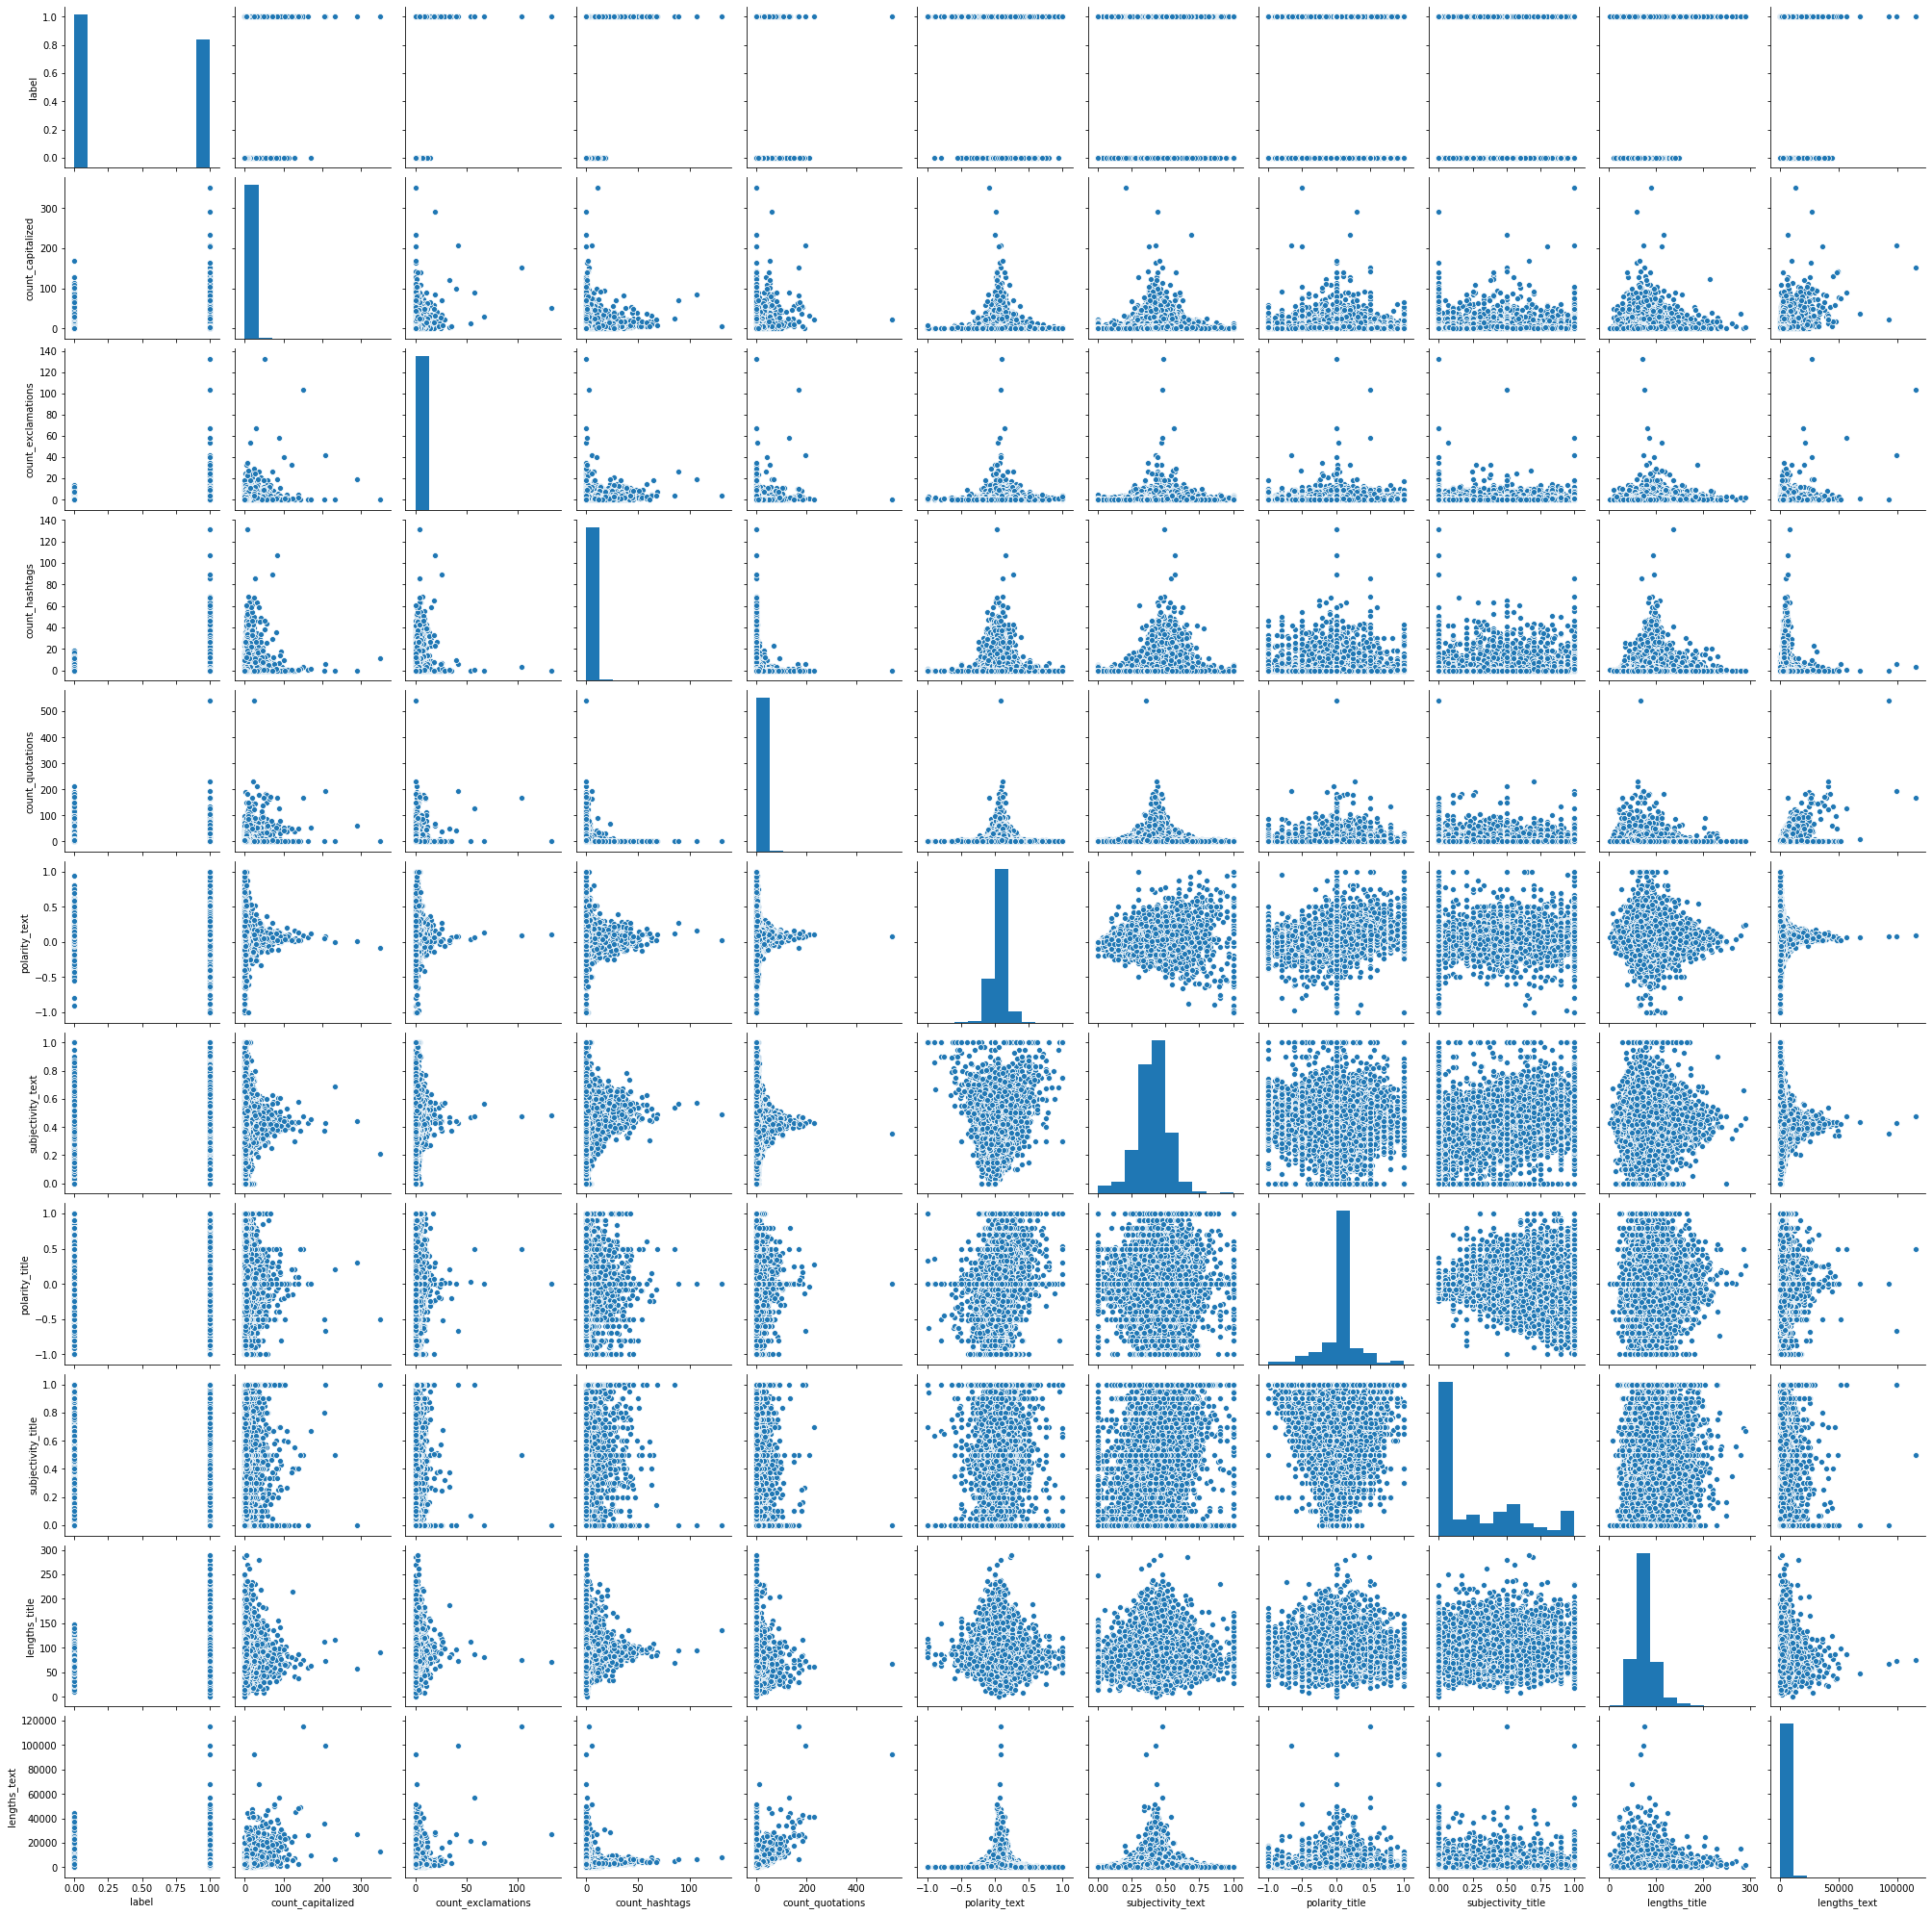

In [109]:
sn.pairplot(df_cleaned)
plt.show()

To avoid this, we will generate a correlation matrix of all the columns in our dataset, and only focus on the visualizations of the fields that show non-negligible correlation (above 0.3).

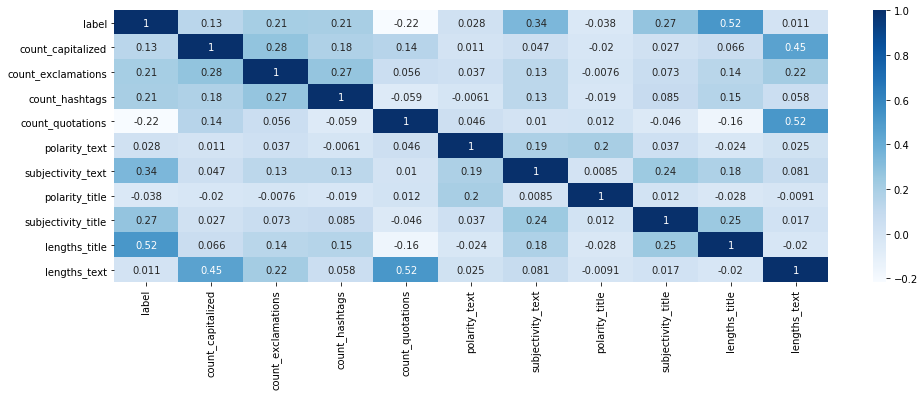

In [110]:
corrMatrix = df_cleaned.corr()
plt.figure(figsize=(16,5))
sn.heatmap(corrMatrix, annot=True, cmap = "Blues")
plt.show()

We can see that only 4 relations have a non-negligible degree of correlation and we will try to interpret exactly those.

- subjectivity_text & label (correlation score of 0.34) - an increase in the subjectivity is related to an increase in the label. Here we keep in mind that label flags whether an article is real (0) or fake (1). In other words, the more subjective a text, the more likely it is fake. This should be helpful in testing one of our hypotheses.

- lengths_title & label (correlation score of 0.52) - an increase in the title length is related to an increase in the label. In other words, the longer a title, the more likely it is fake.

- lengths_text & count_capitalized (correlation score of 0.45) - an increase in the text length is related to an increase in the number of capitalized words.

- lengths_text & count_quotations (correlation score of 0.52) - an increase in the text length is related to an increase in the number of quotations used.

Let us plot some of these relationships.



#### Plotting subjectivity_text & label 

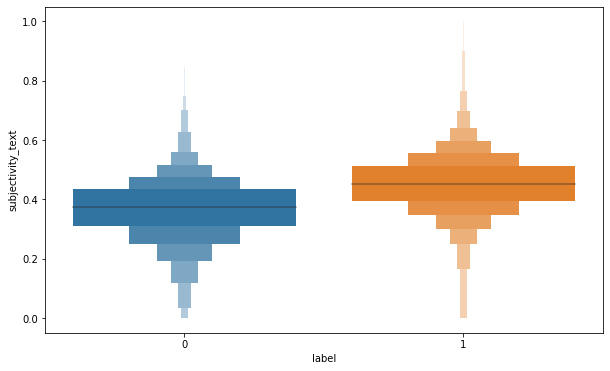

In [111]:
plt.figure(figsize=(10,6))
sn.boxenplot(x='label', y='subjectivity_text', data=df_cleaned)
plt.show()

We can clearly see the increase in subjectivity with the change in label from "real" to "fake".

#### Plotting lengths_title & label 

The same relation is visible for lengths_title & label and here the effect is even visibly stronger.

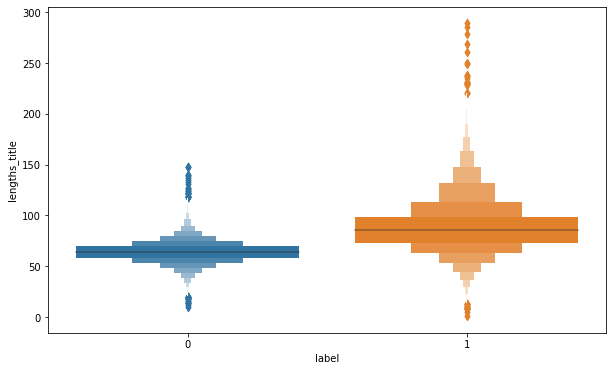

In [112]:
plt.figure(figsize=(10,6))
sn.boxenplot(x='label', y='lengths_title', data=df_cleaned)
plt.show()

#### Plotting lengths_text & count_capitalized

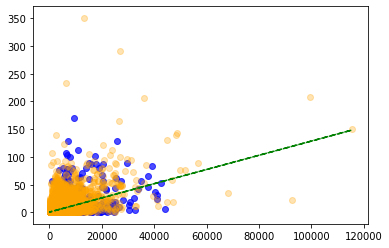

In [113]:
x = df_cleaned["lengths_text"]
y = df_cleaned["count_capitalized"]
x0 = df_cleaned[df_cleaned["label"] == 0]["lengths_text"]
y0 = df_cleaned[df_cleaned["label"] == 0]["count_capitalized"]
x1 = df_cleaned[df_cleaned["label"] == 1]["lengths_text"]
y1 = df_cleaned[df_cleaned["label"] == 1]["count_capitalized"]

plt.scatter(x0, y0, alpha = 0.7, color = "blue")
plt.scatter(x1, y1, alpha = 0.3, color = "orange")


z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", color = "green")

plt.show()

From first look it seems that the fake lengths of texts are more dispersed than the real ones. Let us zoom in and see if this situation changes.

In [114]:
zoom_in = df_cleaned[(df_cleaned["lengths_text"] < 50000) & (df_cleaned["count_capitalized"] < 150)]

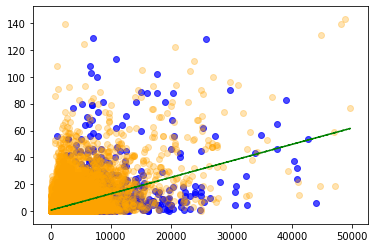

In [115]:
x = zoom_in["lengths_text"]
y = zoom_in["count_capitalized"]
x0 = zoom_in[zoom_in["label"] == 0]["lengths_text"]
y0 = zoom_in[zoom_in["label"] == 0]["count_capitalized"]
x1 = zoom_in[zoom_in["label"] == 1]["lengths_text"]
y1 = zoom_in[zoom_in["label"] == 1]["count_capitalized"]

plt.scatter(x0, y0, alpha = 0.7, color = "blue")
plt.scatter(x1, y1, alpha = 0.3, color = "orange")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", color = "green")

plt.show()

Here the dispersion does not seem to differ between the two categories.

In [116]:
zoom_in_further = df_cleaned[(df_cleaned["lengths_text"] < 15000) & (df_cleaned["count_capitalized"] < 50)]

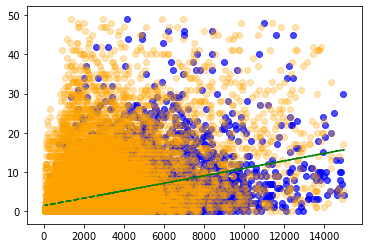

In [117]:
x = zoom_in_further["lengths_text"]
y = zoom_in_further["count_capitalized"]
x0 = zoom_in_further[zoom_in_further["label"] == 0]["lengths_text"]
y0 = zoom_in_further[zoom_in_further["label"] == 0]["count_capitalized"]
x1 = zoom_in_further[zoom_in_further["label"] == 1]["lengths_text"]
y1 = zoom_in_further[zoom_in_further["label"] == 1]["count_capitalized"]

plt.scatter(x0, y0, alpha = 0.7, color = "blue")
plt.scatter(x1, y1, alpha = 0.3, color = "orange")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", color = "green")

plt.show()

And here the data is just too messy to make any sense of.

#### Plotting lengths_text & count_quotations

We repeat the same for lengths_text & count_quotations.

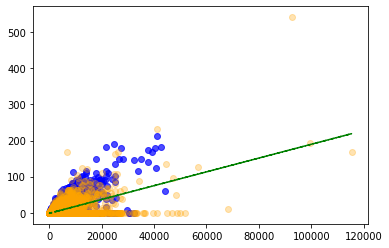

In [118]:
x = df_cleaned["lengths_text"]
y = df_cleaned["count_quotations"]
x0 = df_cleaned[df_cleaned["label"] == 0]["lengths_text"]
y0 = df_cleaned[df_cleaned["label"] == 0]["count_quotations"]
x1 = df_cleaned[df_cleaned["label"] == 1]["lengths_text"]
y1 = df_cleaned[df_cleaned["label"] == 1]["count_quotations"]

plt.scatter(x0, y0, alpha = 0.7, color = "blue")
plt.scatter(x1, y1, alpha = 0.3, color = "orange")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", color = "green")

plt.show()

In [119]:
zoom_in = df_cleaned[(df_cleaned["lengths_text"] < 50000) & (df_cleaned["count_quotations"] < 250)]

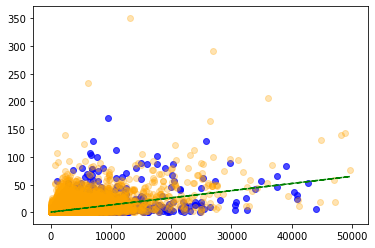

In [120]:
x = zoom_in["lengths_text"]
y = zoom_in["count_capitalized"]
x0 = zoom_in[zoom_in["label"] == 0]["lengths_text"]
y0 = zoom_in[zoom_in["label"] == 0]["count_capitalized"]
x1 = zoom_in[zoom_in["label"] == 1]["lengths_text"]
y1 = zoom_in[zoom_in["label"] == 1]["count_capitalized"]

plt.scatter(x0, y0, alpha = 0.7, color = "blue")
plt.scatter(x1, y1, alpha = 0.3, color = "orange")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", color = "green")

plt.show()

No obvious patterns can be seen from this plot, however the trendline shows the obvious correlation between the two columns.

## Testing the Hypotheses


To do that, we will stick to the following analysis plan: 
- We will look at correlations
- Plot the distributions
- And last but not least, perform a t-test on the two groups - real and fake.

#### Upper Case Words

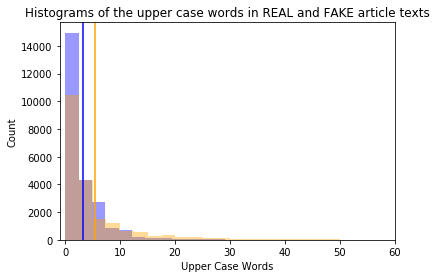

In [121]:
plt.title("Histograms of the upper case words in REAL and FAKE article texts")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["count_capitalized"], bins = 70, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["count_capitalized"], bins = 140, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["count_capitalized"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["count_capitalized"].mean(), c = "orange")

plt.xlabel("Upper Case Words")
plt.ylabel("Count")
plt.xlim(right = 60, left = -1)

plt.show()

In [122]:
def check_statistics(column1, column2):
    print("Mean: " + "Real = " + str(df_cleaned[df_cleaned[column1] == 1][column2].mean()) + " vs. " + \
         str(df_cleaned[df_cleaned[column1] == 0][column2].mean()) + " = Fake" )
    print("Median: " + "Real = " + str(df_cleaned[df_cleaned[column1] == 1][column2].median())+ " vs. " + \
         str(df_cleaned[df_cleaned[column1] == 0][column2].median()) + " = Fake" )
    print("St.dev: " + "Real = " + str(df_cleaned[df_cleaned[column1] == 1][column2].std())+ " vs. " + \
         str(df_cleaned[df_cleaned[column1] == 0][column2].std()) + " = Fake" )
    print("Kurt: " + "Real = " + str(df_cleaned[df_cleaned[column1] == 1][column2].kurt())+ " vs. " + \
         str(df_cleaned[df_cleaned[column1] == 0][column2].kurt()) + " = Fake" )
    print("Skew: " + "Real = " + str(df_cleaned[df_cleaned[column1] == 1][column2].skew())+ " vs. " + \
         str(df_cleaned[df_cleaned[column1] == 0][column2].skew()) + " = Fake" )

In [123]:
check_statistics("label", "count_capitalized")

Mean: Real = 5.387692157054734 vs. 3.328432379153148 = Fake
Median: Real = 2.0 vs. 2.0 = Fake
St.dev: Real = 9.816911109713292 vs. 5.147976734569164 = Fake
Kurt: Real = 169.6582865723498 vs. 158.74579503736229 = Fake
Skew: Real = 8.49863109581813 vs. 9.162361164386693 = Fake


In [124]:
np.corrcoef(df_cleaned["label"], df_cleaned["count_capitalized"])

array([[1.        , 0.13305243],
       [0.13305243, 1.        ]])

The only noticable difference is the spread of the data: fake articles have a more spread out upper case word counts than real ones. We can confirm the lack of differences by running a t-test. Since the dataset is not balanced, and there are less fake articles than real ones, we will take a sample from each type of news. The sample size will be equal to the size of the fake articles.

Let us see if the mean number of upper case word counts in fake articles is significantly higher than the  upper case word counts in real articles, at confidence level of 1%

In [125]:
sample_size = df_cleaned.label.value_counts()[1]

In [126]:
sample_real_count_capitalized = df_cleaned["count_capitalized"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_count_capitalized = df_cleaned["count_capitalized"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_count_capitalized, sample_fake_count_capitalized)

Ttest_indResult(statistic=-26.514886040326836, pvalue=1.3101573342681174e-153)

As suggested by the correlation scores, the histograms and the results of the t-test, **we fail to reject the null hypothesis**. We conclude that there is no statistically significant difference between the number of capitalized words used in fake and real article.

#### Exclamation Marks

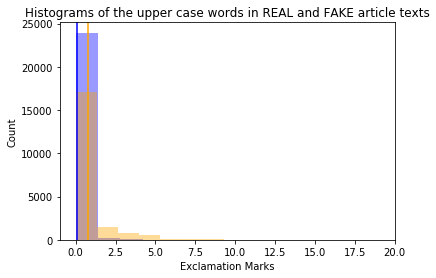

In [127]:
plt.title("Histograms of the upper case words in REAL and FAKE article texts")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["count_exclamations"], bins = 10, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["count_exclamations"], bins = 100, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["count_exclamations"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["count_exclamations"].mean(), c = "orange")

plt.xlabel("Exclamation Marks")
plt.ylabel("Count")
plt.xlim(right = 20, left = -1)

plt.show()

In [128]:
check_statistics("label", "count_exclamations")

Mean: Real = 0.7551160285910115 vs. 0.08805289744958725 = Fake
Median: Real = 0.0 vs. 0.0 = Fake
St.dev: Real = 2.2112773201889384 vs. 0.5163347286312661 = Fake
Kurt: Real = 966.4005025364775 vs. 156.93519998504834 = Fake
Skew: Real = 21.401117359651632 vs. 10.492642339967347 = Fake


In [129]:
np.corrcoef(df_cleaned["label"], df_cleaned["count_exclamations"])

array([[1.        , 0.21072699],
       [0.21072699, 1.        ]])

In [130]:
sample_real_count_exclamations = df_cleaned["count_exclamations"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_count_exclamations = df_cleaned["count_exclamations"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_count_exclamations, sample_fake_count_exclamations)

Ttest_indResult(statistic=-41.841212422038915, pvalue=0.0)

As suggested by the t-test and the histograms **we can reject the null hypothesis at a 1% level**. We conclude that there is statistically significant difference between the number of exclamation marks of fake and real article texts.

#### Hashtags

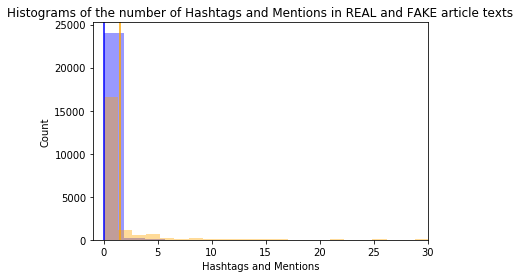

In [131]:
plt.title("Histograms of the number of Hashtags and Mentions in REAL and FAKE article texts")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["count_hashtags"], bins = 10, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["count_hashtags"], bins = 100, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["count_hashtags"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["count_hashtags"].mean(), c = "orange")

plt.xlabel("Hashtags and Mentions")
plt.ylabel("Count")
plt.xlim(right = 30, left = -1)

plt.show()

In [132]:
check_statistics("label", "count_hashtags")

Mean: Real = 1.554929991187702 vs. 0.06661464536531274 = Fake
Median: Real = 0.0 vs. 0.0 = Fake
St.dev: Real = 5.18550313553589 vs. 0.6011854781895863 = Fake
Kurt: Real = 68.93876158608161 vs. 352.60993262823473 = Fake
Skew: Real = 6.689262584887707 vs. 16.21827991847571 = Fake


In [133]:
np.corrcoef(df_cleaned["label"], df_cleaned["count_hashtags"])

array([[1.        , 0.20550203],
       [0.20550203, 1.        ]])

In [134]:
sample_real_count_hashtags = df_cleaned["count_hashtags"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_count_hashtags = df_cleaned["count_hashtags"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_count_hashtags, sample_fake_count_hashtags)

Ttest_indResult(statistic=-40.732504916950866, pvalue=0.0)

As suggested by the t-test and the histograms **we can reject the null hypothesis at a 1% level**. We conclude that there is statistically significant difference between the number of hashtags and mentions in fake and real article texts.

#### Quotations

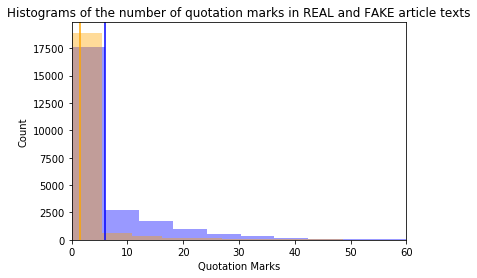

In [135]:
plt.title("Histograms of the number of quotation marks in REAL and FAKE article texts")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["count_quotations"], bins = 35, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["count_quotations"], bins = 100, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["count_quotations"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["count_quotations"].mean(), c = "orange")

plt.xlabel("Quotation Marks")
plt.ylabel("Count")
plt.xlim(right = 60, left = 0)

plt.show()

In [136]:
check_statistics("label", "count_quotations")

Mean: Real = 1.542250073435817 vs. 5.939094007967473 = Fake
Median: Real = 0.0 vs. 0.0 = Fake
St.dev: Real = 8.20550025457009 vs. 11.031409441546147 = Fake
Kurt: Real = 1025.0318380092085 vs. 41.17384249256392 = Fake
Skew: Real = 21.220290776845946 vs. 4.508572194704438 = Fake


In [137]:
np.corrcoef(df_cleaned["label"], df_cleaned["count_quotations"])

array([[ 1.        , -0.21717542],
       [-0.21717542,  1.        ]])

In [138]:
sample_real_count_quotations = df_cleaned["count_quotations"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_count_quotations = df_cleaned["count_quotations"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_count_quotations, sample_fake_count_quotations)

Ttest_indResult(statistic=45.45194040144455, pvalue=0.0)

As suggested by the t-test and the histograms **we can reject the null hypothesis at a 1% level**. We conclude that there is statistically significant difference between the number of quotations in fake and real article texts.

#### Title subjectivity

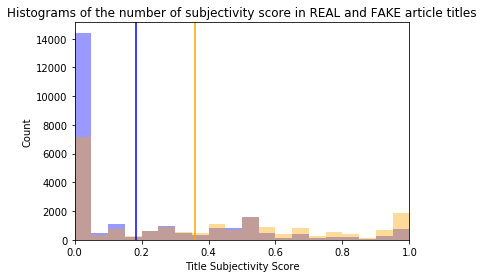

In [139]:
plt.title("Histograms of the number of subjectivity score in REAL and FAKE article titles")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["subjectivity_title"], bins = 20, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["subjectivity_title"], bins = 20, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["subjectivity_title"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["subjectivity_title"].mean(), c = "orange")

plt.xlabel("Title Subjectivity Score")
plt.ylabel("Count")
plt.xlim(right = 1, left = 0)

plt.show()

In [140]:
check_statistics("label", "subjectivity_title")

Mean: Real = 0.3592293153635273 vs. 0.18316406685600456 = Fake
Median: Real = 0.32727272727272727 vs. 0.0 = Fake
St.dev: Real = 0.3465453323998485 vs. 0.277068727103117 = Fake
Kurt: Real = -1.0879542067532713 vs. 1.07370290205585 = Fake
Skew: Real = 0.47634539277644544 vs. 1.4339691693103467 = Fake


In [141]:
np.corrcoef(df_cleaned["label"], df_cleaned["subjectivity_title"])

array([[1.        , 0.27164301],
       [0.27164301, 1.        ]])

In [142]:
sample_real_subjectivity_title = df_cleaned["subjectivity_title"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_subjectivity_title = df_cleaned["subjectivity_title"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_subjectivity_title, sample_fake_subjectivity_title)

Ttest_indResult(statistic=-56.853946326724575, pvalue=0.0)

As suggested by the t-test and the histograms **we can reject the null hypothesis at a 1% level**. We conclude that there is statistically significant difference between the subjectivity score of fake and real article titles.

#### Text subjectivity

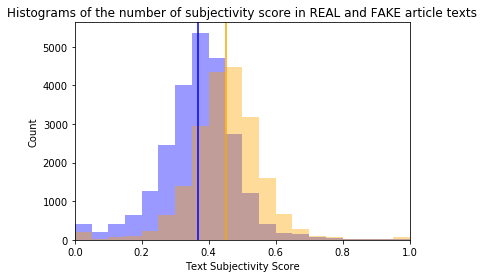

In [143]:
plt.title("Histograms of the number of subjectivity score in REAL and FAKE article texts")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["subjectivity_text"], bins = 20, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["subjectivity_text"], bins = 20, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["subjectivity_text"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["subjectivity_text"].mean(), c = "orange")

plt.xlabel("Text Subjectivity Score")
plt.ylabel("Count")
plt.xlim(right = 1, left = 0)

plt.show()

In [144]:
check_statistics("label", "subjectivity_text")

Mean: Real = 0.45122703782853 vs. 0.3686197839409363 = Fake
Median: Real = 0.45274996993747 vs. 0.3757809184279773 = Fake
St.dev: Real = 0.1113666908830778 vs. 0.11542301240006393 = Fake
Kurt: Real = 4.308175838033737 vs. 2.613140150075781 = Fake
Skew: Real = -0.1304802507217883 vs. -0.154589026688465 = Fake


In [145]:
np.corrcoef(df_cleaned["label"], df_cleaned["subjectivity_text"])

array([[1.        , 0.34057354],
       [0.34057354, 1.        ]])

In [146]:
sample_real_subjectivity_text = df_cleaned["subjectivity_text"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_subjectivity_text = df_cleaned["subjectivity_text"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_subjectivity_text, sample_fake_subjectivity_text)

Ttest_indResult(statistic=-73.22740211915246, pvalue=0.0)

As suggested by the t-test and the histograms **we can reject the null hypothesis at a 1% level**. We conclude that there is statistically significant difference between the subjectivity score of fake and real article texts.

#### Title polarity
First we check the distribution of the title polarity scores among real and fake articles.

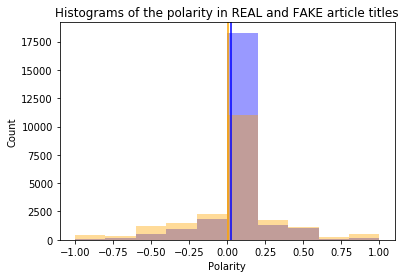

In [147]:
plt.title("Histograms of the polarity in REAL and FAKE article titles")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["polarity_title"], bins = 10, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["polarity_title"], bins = 10, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["polarity_title"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["polarity_title"].mean(), c = "orange")

plt.xlabel("Polarity")
plt.ylabel("Count")

plt.show()

At first look, the distributions between real and fake article titles look quite similar, with the only difference being the kurtosis. Let us run some descriptive statistics and verify that.

In [148]:
check_statistics("label", "polarity_title")

Mean: Real = 0.0056619043155876824 vs. 0.025505290419686015 = Fake
Median: Real = 0.0 vs. 0.0 = Fake
St.dev: Real = 0.31777955009538295 vs. 0.19157668783695864 = Fake
Kurt: Real = 2.2643752814992317 vs. 6.130889570938415 = Fake
Skew: Real = -0.1517413310685457 vs. 0.32310531348198 = Fake


In [149]:
np.corrcoef(df_cleaned["label"], df_cleaned["polarity_title"])

array([[ 1.        , -0.03843632],
       [-0.03843632,  1.        ]])

Let us see if the mean number of polarity score of the title in fake articles is significantly higher than the polarity score of the title in real articles, at confidence level of 1%.

In [150]:
sample_real_polar_title = df_cleaned["polarity_title"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_polar_title = df_cleaned["polarity_title"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_rel(sample_real_polar_title, sample_fake_polar_title)

Ttest_relResult(statistic=7.663924858128855, pvalue=1.8836642194259213e-14)

As suggested by the correlation scores, the histograms and the results of the t-test, **we fail to reject the null hypothesis**. We conclude that there is no statistically significant difference between the polarity scores of fake and real article titles.

#### Text polarity

Following the same analysis plan for polarity scores of the texts of articles:

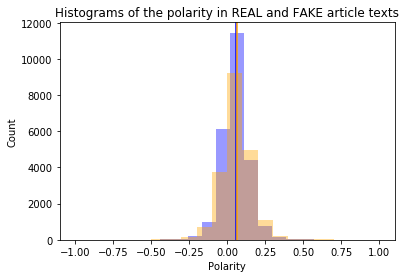

In [151]:
plt.title("Histograms of the polarity in REAL and FAKE article texts")

plt.hist(df_cleaned[df_cleaned["label"] == 0]["polarity_text"], bins = 20, color = "blue", alpha = 0.4)
plt.hist(df_cleaned[df_cleaned["label"] == 1]["polarity_text"], bins = 20, color = "orange", alpha = 0.4)
plt.axvline(df_cleaned[df_cleaned["label"] == 0]["polarity_text"].mean(), c = "blue")
plt.axvline(df_cleaned[df_cleaned["label"] == 1]["polarity_text"].mean(), c = "orange")

plt.xlabel("Polarity")
plt.ylabel("Count")

plt.show()

In [152]:
check_statistics("label", "polarity_text")

Mean: Real = 0.06255972618202253 vs. 0.05683415990806796 = Fake
Median: Real = 0.06059530446705773 vs. 0.05611111111111112 = Fake
St.dev: Real = 0.11505263633403859 vs. 0.09065806523051241 = Fake
Kurt: Real = 11.305314844379579 vs. 5.9738913442165895 = Fake
Skew: Real = 0.24338886273367863 vs. 0.19712565732884124 = Fake


In [153]:
np.corrcoef(df_cleaned["label"], df_cleaned["polarity_text"])

array([[1.        , 0.02780953],
       [0.02780953, 1.        ]])

In [154]:
sample_real_polar_text = df_cleaned["polarity_text"][df_cleaned["label"] == 0].sample(sample_size)
sample_fake_polar_text = df_cleaned["polarity_text"][df_cleaned["label"] == 1].sample(sample_size)
st.ttest_ind(sample_real_polar_text, sample_fake_polar_text)

Ttest_indResult(statistic=-5.2616141415064615, pvalue=1.435151872713875e-07)

As suggested by the correlation scores, the histograms and the results of the t-test, **we fail to reject the null hypothesis**. We conclude that there is no statistically significant difference between the polarity scores of fake and real article texts.

## Building a Fake News Classifier

Now that we have tested our hypotheses related to the punctuation, capitalization and other text characteristics, we can clean the text column for NLP purposes. We would like to only keep the alphabet characters, and remove all digits, symbols and punctuation. We start by tokenizing the words from each text.

In [155]:
word_tokens = [word_tokenize(text) for text in df_cleaned["text"]]

In [156]:
word_tokens[:1]

[['A',
  'Dallas',
  'police',
  'officer',
  ',',
  'seeing',
  'red',
  'after',
  'several',
  'shootings',
  'of',
  'police',
  'officers',
  ',',
  'has',
  'decided',
  'he',
  's',
  'had',
  'enough',
  'and',
  'he',
  'and',
  'his',
  'lawyer',
  ',',
  'are',
  'going',
  'to',
  'punish',
  'everyone',
  'they',
  'absolutely',
  'can',
  'for',
  'allegedly',
  'conspiring',
  'to',
  'create',
  'a',
  'race',
  'war',
  '.',
  'Yes',
  ',',
  'this',
  'is',
  'the',
  'same',
  'race',
  'war',
  'that',
  'the',
  'entire',
  'right',
  'sees',
  'whenever',
  'people',
  'call',
  'attention',
  'to',
  'the',
  'racism',
  'that',
  'permeates',
  'our',
  'justice',
  'system.Police',
  'Sergeant',
  'Demetrick',
  'Pennie',
  ',',
  'a',
  '17-year',
  'veteran',
  'of',
  'the',
  'Dallas',
  'police',
  'force',
  ',',
  'is',
  'suing',
  'leaders',
  'of',
  'the',
  'Black',
  'Lives',
  'Matter',
  'movement',
  'along',
  'with',
  'the',
  'Rev',
  '.',
 

After that we only filter the strings with alphabet characters and remove any capitalization.

In [157]:
cleaned_tokens = [[word.lower() for word in item if word.isalpha()] for item in word_tokens]

In [158]:
cleaned_tokens[:1]

[['a',
  'dallas',
  'police',
  'officer',
  'seeing',
  'red',
  'after',
  'several',
  'shootings',
  'of',
  'police',
  'officers',
  'has',
  'decided',
  'he',
  's',
  'had',
  'enough',
  'and',
  'he',
  'and',
  'his',
  'lawyer',
  'are',
  'going',
  'to',
  'punish',
  'everyone',
  'they',
  'absolutely',
  'can',
  'for',
  'allegedly',
  'conspiring',
  'to',
  'create',
  'a',
  'race',
  'war',
  'yes',
  'this',
  'is',
  'the',
  'same',
  'race',
  'war',
  'that',
  'the',
  'entire',
  'right',
  'sees',
  'whenever',
  'people',
  'call',
  'attention',
  'to',
  'the',
  'racism',
  'that',
  'permeates',
  'our',
  'justice',
  'sergeant',
  'demetrick',
  'pennie',
  'a',
  'veteran',
  'of',
  'the',
  'dallas',
  'police',
  'force',
  'is',
  'suing',
  'leaders',
  'of',
  'the',
  'black',
  'lives',
  'matter',
  'movement',
  'along',
  'with',
  'the',
  'rev',
  'al',
  'sharpton',
  'billionaire',
  'george',
  'soros',
  'louis',
  'farrakhan',
 

Last but not least we add the cleaned texts to a separate column in our dataset.

In [159]:
df_cleaned["text_clean"] = [' '.join(x) for x in cleaned_tokens]

In [160]:
df_cleaned.shape

(44775, 16)

Let us visualize the words that we have jsut cleaned and prepared for NLP. We will generate a wordcloud for both the real and fake articles.

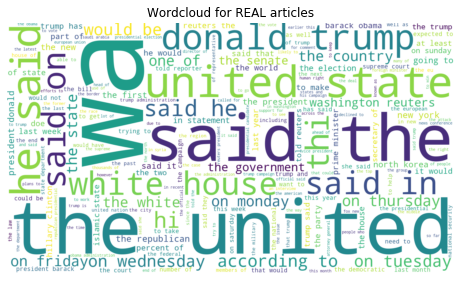

In [161]:
# Create and generate a word cloud image
my_stopwords = set(stopwords.words("english"))

word_cloud_real = WordCloud(width = 1600, height = 900,
                            background_color='white',
                           stopwords = my_stopwords
                           ).generate(" ".join(df_cleaned[df_cleaned['label'] == 0].text_clean))
 
# Display the generated wordcloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud_real, interpolation='bilinear') 
plt.axis("off")
plt.title("Wordcloud for REAL articles")

# Don't forget to show the final image
plt.show()

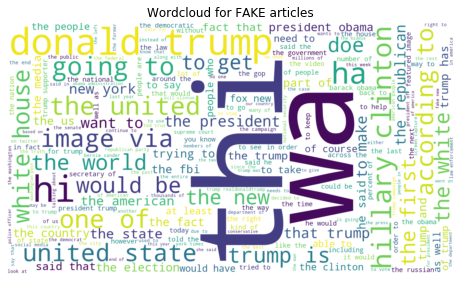

In [162]:
# Create and generate a word cloud image
my_stopwords = set(stopwords.words("english"))

word_cloud_real = WordCloud(width = 1600, height = 900,
                            background_color='white',
                           stopwords = my_stopwords
                           ).generate(" ".join(df_cleaned[df_cleaned['label'] == 1].text_clean))
 
# Display the generated wordcloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud_real, interpolation='bilinear') 
plt.axis("off")
plt.title("Wordcloud for FAKE articles")

# Don't forget to show the final image
plt.show()

The wordclouds make it quite obvious that the news are related mainly to politics and the USA.

We want to try to predict whether an article is real or fake based solely on its words. To do so we will build two models - one Logistic regression and one Multinomial Naive Bayes classifier. 

They both will be trained on one part of the dataset and will be tested on another. Therefore we go on and split our dataset in two subsets. We will train the models on 70% of the data and test them on the remaining 30%

In [163]:
#splitting data for training and testing
import sklearn
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df_cleaned['text_clean'],df_cleaned['label'],test_size=0.3, random_state = 42)

In [164]:
print("The training set contains " + str(len(x_train)) + " observations.")
print("The test set contains " + str(len(x_test)) + " observations.")

The training set contains 31342 observations.
The test set contains 13433 observations.


To build our models, we will use several Python modules. We will firstly generate a count vectorizer of all the words that we have cleaned and prepared. This vectorizer will then be transformed into a Tf-Idf vectorizer using TfidfTransformer(). Lastly the trained data will be fed to a MultinomialNB() function. The corresponding results we will visualize with the help of a confusion matrix.

Accuracy: 87.91%


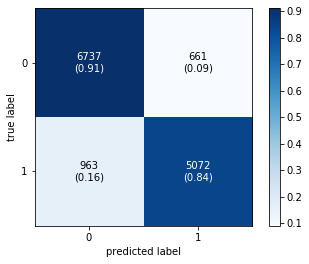

In [165]:
MultinomialNB = Pipeline([
    ('vect', CountVectorizer(max_features = 200,
                             stop_words = stopwords.words('english'),
                             ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

model = MultinomialNB.fit(x_train, y_train)
prediction = model.predict(x_test)

score = metrics.accuracy_score(y_test, prediction)

print(f'Accuracy: {round(score*100,2)}%')

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Accuracy: 94.61%


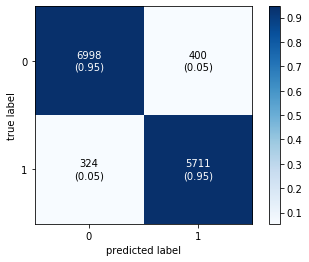

In [166]:
LogisticRegression = Pipeline([
    ('vect', CountVectorizer(max_features = 200,
                             stop_words = stopwords.words('english'),
                             ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

model = LogisticRegression.fit(x_train, y_train)
prediction = model.predict(x_test)

score = metrics.accuracy_score(y_test, prediction)
print(f'Accuracy: {round(score*100,2)}%')

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

As we see, the Logistic Regression Model more accurately predicts the test data than the Naive Bayes one. We find support for such results from an article by Andrew Ng [8], whose findings suggest that a logistic regression model is more accurate with large datasets. Still, more research needs to be done to figure our the reason behind these results.

## Concluding remarks

A lot can be done here to try to improve our study. 

For example, our classifiers can be improved by adjusting the max_features, max_df and min_df parameters of the Count vectorizer. 

Additionaly, using differnet n-grams and comparing how they perform seems interesting. 

Last but not least improving the data quality by combining several stopword lists, by using stemming and lemmatization, or by more thoroughly cleaning the texts would most likely yield better results. 

### References

[1] https://www.azlyrics.com/lyrics/faithless/massdestruction.html

[2] https://www.bbc.co.uk/bitesize/articles/zjykkmn

[3] https://www.ft.com/content/01622cd8-5303-11ea-90ad-25e377c0ee1f

[4] https://theconversation.com/fake-news-emotions-and-experiences-not-more-data-could-be-the-antidote-123496

[5] https://www.meaningcloud.com/blog/case-study-text-analytics-against-fake-news

[6] https://www.kaggle.com/shaguns26/fake-news-detection-naive-bayes-model

[7] https://www.kaggle.com/leo2510/fake-news-classification

[8] http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf


### Data 

The datasets can be downloaded from here: 
[9] https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

and here:
[10] https://www.kaggle.com/vikasukani/news-data-set-fake-news-with-python